In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
import pandas as pd

%matplotlib inline

Some notes: https://docs.google.com/spreadsheets/d/1cGzdcvdqpMCH12-PpyXxDNDFYd6ZwCTUwboeO8DeVa0/edit?usp=sharing

1.1
Implement a multi-class, multi-layer perceptron with cross-entropy loss for the FashionMNIST data.

The first step, as with any project you’ll work on, is data preprocessing. We need to transform the raw dataset into tensors and normalize them in a fixed range. The torchvision package provides a utility called transforms which can be used to combine different transformations together.

The first transformation converts the raw data into tensor variables and the second transformation performs normalization using the below operation:

x_normalized = x-mean / std

We only have one channel, so one value for mean and one for std

In [3]:
transform_tasks = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])

In [4]:
train_dataset = datasets.FashionMNIST('FMNIST/',
                              train=True,
                              download=True,
                              transform=transform_tasks)

test_dataset = datasets.FashionMNIST('FMNIST/',
                              train=False,
                              download=True,
                              transform=transform_tasks)

Extracting FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FMNIST/FashionMNIST/raw


Extracting FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FMNIST/FashionMNIST/raw



Extracting FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FMNIST/FashionMNIST/raw


Extracting FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
labels_map = {0 : 'T-shirt', 1 : 'Trousers', 2 : 'Sweater', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Boot'}

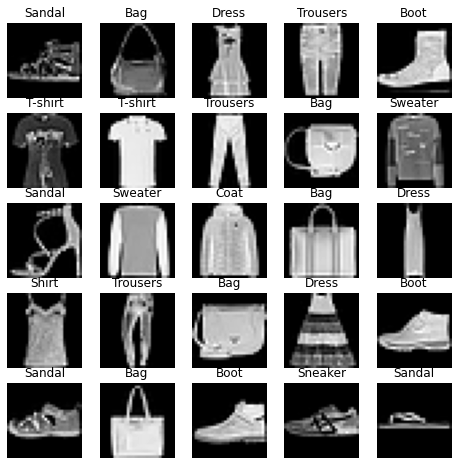

In [6]:
fig = plt.figure(figsize=(8,8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

In [8]:
batch_size  = 100   # Using minibatches of 100 samples

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [10]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size)

In [11]:
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=5000) # validation set has 5000 entries

In [12]:
dev_test_data=list(iter(validation_loader))
dev_images,dev_labels=dev_test_data[0]
test_images,test_labels=dev_test_data[1]

In [14]:
test_images=test_images.reshape(-1,784)
dev_images=dev_images.reshape(-1,784)

In [16]:
# specify loss function
criterion = nn.CrossEntropyLoss()

Now, we want to consider: NN with {2, 3} hidden layers dimensionality of powers of 2 - {28**2 (input), 512, 256, 128, 64, 32, 10 (output)}, dropouts with probs 0.1 and 0.2 (apparently those are the best options to be used after each layer), Relu activation function (need to justify why), momentums out of {0, 0.1, 0.5, 0.9}.

2 hidden layers

In [3]:
## Define the NN architecture 
# params: neurons - a list of neuron numbers in each layer
#         dropout  - dropout cause why not
class Net(nn.Module):
    def __init__(self, neurons, dropout):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 ** 2, neurons[0])
        self.fc2 = nn.Linear(neurons[0], neurons[1])
        if len(neurons) == 3:
          self.fc3 = nn.Linear(neurons[1], neurons[2])
          self.fc4 = nn.Linear(neurons[2], 10)
        else:
          self.fc3 = nn.Linear(neurons[1], 10)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(dropout)

# params:
#         n_layers - number of hidden layers in the network
    def forward(self, x, n_layers):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        if n_layers == 3:
          x = F.relu(self.fc3(x))
          x = self.dropout(x)
          x = self.fc4(x)
        else:
          x = self.fc3(x)
        return x


In [18]:
# parameters used to construct models
neurons1 = [512, 256, 128]
neurons2 = [256, 128, 64]
neurons3 = [128, 64, 32]
neurons4 = [512, 256]
neurons5 = [512, 128]
neurons6 = [256, 128]
neurons7 = [256, 64]
neurons8 = [128, 64]

dropout1 = 0.1
dropout2 = 0.2

Define 3 layer models

In [19]:
models_3_layer = [Net(neurons1, dropout1), Net(neurons2, dropout1), Net(neurons3, dropout1), 
                  Net(neurons1, dropout2), Net(neurons2, dropout2), Net(neurons3, dropout2)]

Define 2 layer models

In [20]:
models_2_layer = [Net(neurons4, dropout1), Net(neurons5, dropout1), Net(neurons6, dropout1), Net(neurons7, dropout1), Net(neurons8, dropout1), 
                  Net(neurons4, dropout2), Net(neurons5, dropout2), Net(neurons6, dropout2), Net(neurons7, dropout2), Net(neurons8, dropout2)]

In [21]:
# resets model weights so the model can retrain with different parameters
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [21]:
# shows smooth conversion an 89% accuracy - there was a model with 90% accuracy but erratic convergence and it overfitted very quickly
best_model = models_2_layer[0]

In [24]:
# best learning hyperparameters
optimizer = torch.optim.SGD(best_model.parameters(), lr=0.001, momentum = 0.5)

train_losses = []
train_accs = []

dev_losses = []
dev_accs = []

best_model.train() # prep model for training

for epoch in range(300):
  # monitor training loss and accuracy
  train_loss = 0.0
  train_acc = 0.0

  # monitor validation loss and accuracy
  dev_loss = 0.0
  dev_acc = 0.0

  for images, labels in train_loader:
      X = images.view(-1,784)

      # clear gradients of optimized variables
      optimizer.zero_grad()

      # forward pass
      output = best_model(X, 2)
      loss = criterion(output, labels)
      
      result = torch.argmax(output, dim=1)

      train_loss+=loss.item()
      train_acc+=torch.mean((result==labels).type(torch.float))
      
      loss.backward()
      # update parameters
      optimizer.step()
  else:
      train_loss=train_loss/len(train_loader)
      train_acc=train_acc/len(train_loader)
      
      # disable gradient calculation
      with torch.no_grad():
          best_model.eval()
          output=best_model(dev_images, 2)
          dev_loss=criterion(output,dev_labels)
          best_model.train()
      
      result_labels=torch.argmax(output,dim=1)
      dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
      
      train_losses.append(train_loss)
      dev_losses.append(dev_loss.item())
      
      train_accs.append(train_acc.item())
      dev_accs.append(dev_acc.item())
      
      if (epoch+1) % 10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
          epoch+1, 
          train_loss,
          dev_loss,
          train_acc,
          dev_acc
          ))

Epoch: 10 	Training Loss: 0.583956 	Validation Loss: 0.573460  	Train acc: 0.789416 	Validation acc: 0.792400
Epoch: 20 	Training Loss: 0.487882 	Validation Loss: 0.489753  	Train acc: 0.824199 	Validation acc: 0.825200
Epoch: 30 	Training Loss: 0.444699 	Validation Loss: 0.453724  	Train acc: 0.841149 	Validation acc: 0.841200
Epoch: 40 	Training Loss: 0.414845 	Validation Loss: 0.431229  	Train acc: 0.851082 	Validation acc: 0.848000
Epoch: 50 	Training Loss: 0.392556 	Validation Loss: 0.414157  	Train acc: 0.859583 	Validation acc: 0.851400
Epoch: 60 	Training Loss: 0.374453 	Validation Loss: 0.400359  	Train acc: 0.866100 	Validation acc: 0.857800
Epoch: 70 	Training Loss: 0.359508 	Validation Loss: 0.390397  	Train acc: 0.872550 	Validation acc: 0.862800
Epoch: 80 	Training Loss: 0.347486 	Validation Loss: 0.381758  	Train acc: 0.876600 	Validation acc: 0.864800
Epoch: 90 	Training Loss: 0.336748 	Validation Loss: 0.375107  	Train acc: 0.880000 	Validation acc: 0.869400
Epoch: 100

NameError: ignored

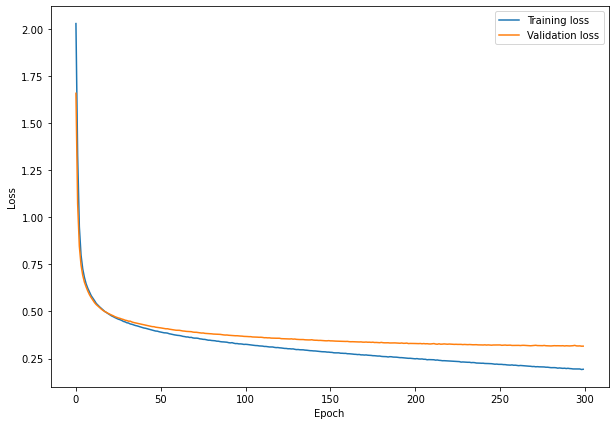

In [35]:
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

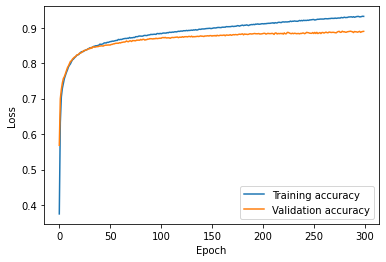

In [36]:
plt.plot(train_accs, label='Training accuracy')
plt.plot(dev_accs, label='Validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

Run on test set:

In [94]:
def predict(model,images):
    conf_matrix = np.zeros((10,10))
    with torch.no_grad():
        model.eval()
        output=model(test_images, 2)
        test_loss=criterion(output,test_labels)
        result=torch.argmax(output,dim=1)
        result_labels=[labels_map[x] for x in result.numpy()]

        for i in range(test_labels.size(0)):
          lbl = test_labels.data[i]
          conf_matrix[lbl][result.data[i]] += 1
    accuracy=torch.mean((result==test_labels).type(torch.float))
    return accuracy, test_loss, result, result_labels, conf_matrix

In [95]:
test_acc, test_loss, result, result_labels, conf_matrix=predict(best_model,test_images)

In [96]:
print('Final training set accuracy: {:.2f}'.format(train_accs[len(train_accs)-1]))
print('Final validation set accuracy: {:.2f}'.format(dev_accs[len(dev_accs)-1]))
print('Final test set accuracy: {:.2f}'.format(test_acc))

Final training set accuracy: 0.93
Final validation set accuracy: 0.89
Final test set accuracy: 0.89


In [98]:
report=pd.DataFrame.from_dict(classification_report(result, test_labels, output_dict=True)).T
report['Label']=[labels_map.get(int(x)) if x.isdigit() else " " for x in report.index]

The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.



In [99]:
# the first line is needed to have labels on the left
report=report[['Label','f1-score','precision','recall']]
report

,Label,f1-score,precision,recall
0,T-shirt,0.835759,0.815416,0.857143
1,Trousers,0.975562,0.961464,0.990079
2,Sweater,0.826446,0.835073,0.817996
3,Dress,0.894164,0.904000,0.884540
4,Coat,0.827727,0.847599,0.808765
5,Sandal,0.966797,0.961165,0.972495
6,Shirt,0.718351,0.706564,0.730539
7,Sneaker,0.947053,0.948000,0.946108
8,Bag,0.969823,0.983122,0.956879
9,Boot,0.954286,0.957935,0.950664


Visualise test data

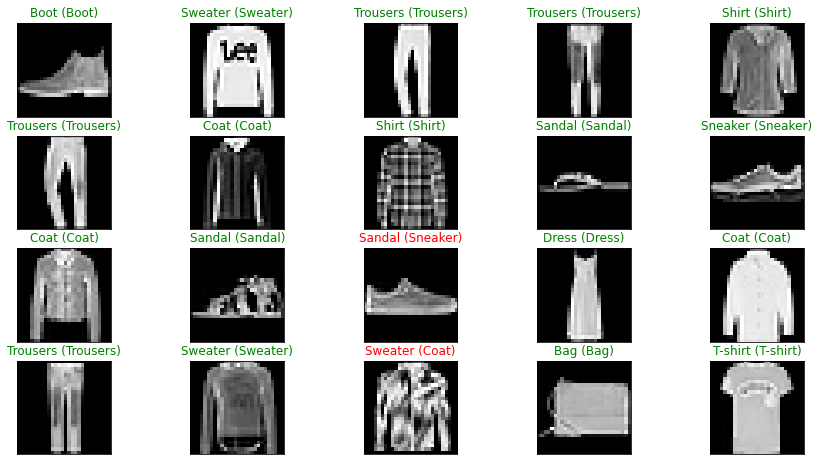

In [91]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = best_model(images, 2)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 20/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(labels_map[preds[idx].item()], labels_map[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

confusion matrix

In [106]:
conf_matrix_pd = df = pd.DataFrame(data=conf_matrix, index=labels_map.values(), columns=labels_map.values())

Text(69.0, 0.5, 'True')

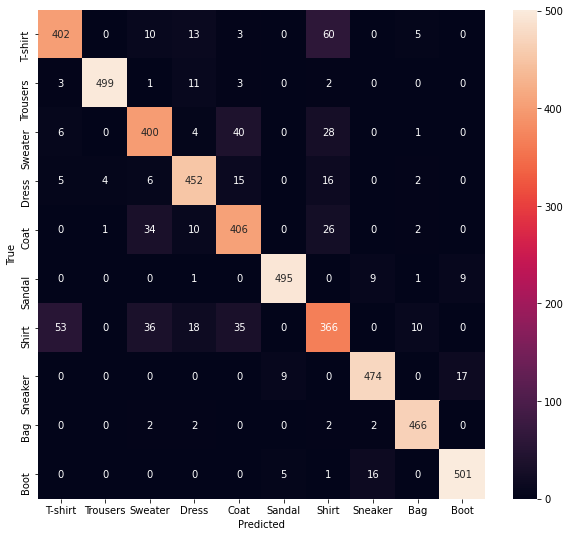

In [115]:
import seaborn as sns
plt.subplots(figsize=(10,9))
ax = sns.heatmap(conf_matrix_pd, annot=True, fmt='g')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [125]:
# all losses are higher than best model
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 3 layer
Processing model  0
Epoch: 10 	Training Loss: 0.423509 	Validation Loss: 0.427067  	Train acc: 0.847616 	Validation acc: 0.847600
Epoch: 20 	Training Loss: 0.340305 	Validation Loss: 0.370811  	Train acc: 0.876783 	Validation acc: 0.870200
Epoch: 30 	Training Loss: 0.292899 	Validation Loss: 0.354829  	Train acc: 0.893834 	Validation acc: 0.872200
Epoch: 40 	Training Loss: 0.255193 	Validation Loss: 0.333990  	Train acc: 0.909051 	Validation acc: 0.879600
Epoch: 50 	Training Loss: 0.225338 	Validation Loss: 0.329756  	Train acc: 0.917834 	Validation acc: 0.885800
Epoch: 60 	Training Loss: 0.197594 	Validation Loss: 0.339311  	Train acc: 0.929435 	Validation acc: 0.883000
Epoch: 70 	Training Loss: 0.172586 	Validation Loss: 0.327174  	Train acc: 0.937567 	Validation acc: 0.889200
Epoch: 80 	Training Loss: 0.150333 	Validation Loss: 0.332661  	Train acc: 0.946234 	Validation acc: 0.892800
Epoch: 90 	Training Loss: 0.129595 	Validation Loss: 0.340629  	Train acc: 0.9532

In [127]:
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 3 layer
Processing model  0
Epoch: 10 	Training Loss: 0.412229 	Validation Loss: 0.414576  	Train acc: 0.852566 	Validation acc: 0.854000
Epoch: 20 	Training Loss: 0.328820 	Validation Loss: 0.364168  	Train acc: 0.883150 	Validation acc: 0.870400
Epoch: 30 	Training Loss: 0.280552 	Validation Loss: 0.338897  	Train acc: 0.899301 	Validation acc: 0.881200
Epoch: 40 	Training Loss: 0.242739 	Validation Loss: 0.322322  	Train acc: 0.912201 	Validation acc: 0.889000
Epoch: 50 	Training Loss: 0.210838 	Validation Loss: 0.324122  	Train acc: 0.924184 	Validation acc: 0.891200
Epoch: 60 	Training Loss: 0.181612 	Validation Loss: 0.328596  	Train acc: 0.935034 	Validation acc: 0.889600
Epoch: 70 	Training Loss: 0.159518 	Validation Loss: 0.327680  	Train acc: 0.942501 	Validation acc: 0.896000
Epoch: 80 	Training Loss: 0.136500 	Validation Loss: 0.336320  	Train acc: 0.951234 	Validation acc: 0.896200
Epoch: 90 	Training Loss: 0.117190 	Validation Loss: 0.353162  	Train acc: 0.9578

In [128]:
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 3 layer
Processing model  0
Epoch: 10 	Training Loss: 0.351921 	Validation Loss: 0.388123  	Train acc: 0.872900 	Validation acc: 0.857600
Epoch: 20 	Training Loss: 0.274278 	Validation Loss: 0.339362  	Train acc: 0.899967 	Validation acc: 0.878600
Epoch: 30 	Training Loss: 0.224160 	Validation Loss: 0.322868  	Train acc: 0.919117 	Validation acc: 0.888600
Epoch: 40 	Training Loss: 0.185501 	Validation Loss: 0.325269  	Train acc: 0.933301 	Validation acc: 0.892000
Epoch: 50 	Training Loss: 0.152542 	Validation Loss: 0.333024  	Train acc: 0.944185 	Validation acc: 0.893400
Epoch: 60 	Training Loss: 0.123426 	Validation Loss: 0.347590  	Train acc: 0.954634 	Validation acc: 0.890600
Epoch: 70 	Training Loss: 0.101597 	Validation Loss: 0.395059  	Train acc: 0.962866 	Validation acc: 0.890200
Epoch: 80 	Training Loss: 0.084934 	Validation Loss: 0.392919  	Train acc: 0.969500 	Validation acc: 0.890600
Epoch: 90 	Training Loss: 0.072297 	Validation Loss: 0.410860  	Train acc: 0.9734

In [129]:
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 3 layer
Processing model  0
Epoch: 10 	Training Loss: 0.266719 	Validation Loss: 0.349673  	Train acc: 0.901367 	Validation acc: 0.879000
Epoch: 20 	Training Loss: 0.199627 	Validation Loss: 0.356712  	Train acc: 0.925700 	Validation acc: 0.886600
Epoch: 30 	Training Loss: 0.150793 	Validation Loss: 0.361777  	Train acc: 0.942734 	Validation acc: 0.887600
Epoch: 40 	Training Loss: 0.119109 	Validation Loss: 0.372471  	Train acc: 0.954784 	Validation acc: 0.896000
Epoch: 50 	Training Loss: 0.093841 	Validation Loss: 0.469264  	Train acc: 0.963834 	Validation acc: 0.889200
Epoch: 60 	Training Loss: 0.074803 	Validation Loss: 0.461387  	Train acc: 0.971600 	Validation acc: 0.894400
Epoch: 70 	Training Loss: 0.064814 	Validation Loss: 0.472426  	Train acc: 0.975783 	Validation acc: 0.896800
Epoch: 80 	Training Loss: 0.047420 	Validation Loss: 0.535929  	Train acc: 0.981949 	Validation acc: 0.896800
Epoch: 90 	Training Loss: 0.042471 	Validation Loss: 0.554698  	Train acc: 0.9837

In [36]:
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  if i != 3:
    i+=1
    continue
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_accs)
  dev_accs_all.append(dev_accs)

Processing 3 layer
Processing model  3
Epoch: 10 	Training Loss: 0.290724 	Validation Loss: 0.339157  	Train acc: 0.894284 	Validation acc: 0.874800
Epoch: 20 	Training Loss: 0.224350 	Validation Loss: 0.340243  	Train acc: 0.916268 	Validation acc: 0.880200
Epoch: 30 	Training Loss: 0.186986 	Validation Loss: 0.336764  	Train acc: 0.929467 	Validation acc: 0.891000
Epoch: 40 	Training Loss: 0.153573 	Validation Loss: 0.335989  	Train acc: 0.941701 	Validation acc: 0.900000
Epoch: 50 	Training Loss: 0.131103 	Validation Loss: 0.359031  	Train acc: 0.951068 	Validation acc: 0.895200
Epoch: 60 	Training Loss: 0.111841 	Validation Loss: 0.400548  	Train acc: 0.957850 	Validation acc: 0.898000
Epoch: 70 	Training Loss: 0.094944 	Validation Loss: 0.403386  	Train acc: 0.964451 	Validation acc: 0.898000
Epoch: 80 	Training Loss: 0.083908 	Validation Loss: 0.411952  	Train acc: 0.968233 	Validation acc: 0.899600
Epoch: 90 	Training Loss: 0.072174 	Validation Loss: 0.458059  	Train acc: 0.9726

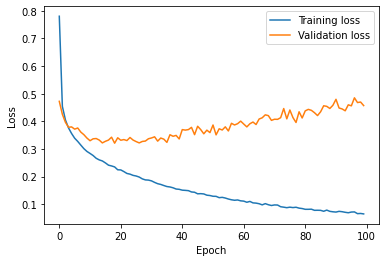

In [37]:
plt.plot(train_losses_all[len(train_losses_all)-1], label='Training loss')
plt.plot(dev_losses_all[len(dev_losses_all)-1], label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

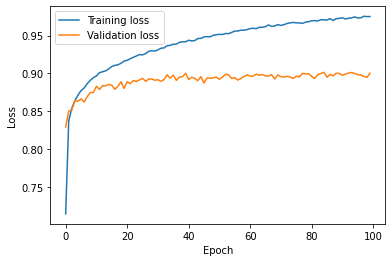

In [39]:
plt.plot(train_accs_all[len(train_accs_all)-1], label='Training loss')
plt.plot(dev_accs_all[len(dev_accs_all)-1], label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [ ]:
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 3 layer
Processing model  0
Epoch: 10 	Training Loss: 0.932409 	Validation Loss: 0.868012  	Train acc: 0.666701 	Validation acc: 0.707600
Epoch: 20 	Training Loss: 0.684432 	Validation Loss: 0.653775  	Train acc: 0.746767 	Validation acc: 0.757200
Epoch: 30 	Training Loss: 0.594964 	Validation Loss: 0.577444  	Train acc: 0.782366 	Validation acc: 0.789200
Epoch: 40 	Training Loss: 0.541257 	Validation Loss: 0.526783  	Train acc: 0.804266 	Validation acc: 0.809000
Epoch: 50 	Training Loss: 0.502712 	Validation Loss: 0.493826  	Train acc: 0.819132 	Validation acc: 0.821800
Epoch: 60 	Training Loss: 0.475848 	Validation Loss: 0.470602  	Train acc: 0.829116 	Validation acc: 0.832200
Epoch: 70 	Training Loss: 0.455087 	Validation Loss: 0.453632  	Train acc: 0.836316 	Validation acc: 0.841400
Epoch: 80 	Training Loss: 0.436162 	Validation Loss: 0.440353  	Train acc: 0.844183 	Validation acc: 0.845200
Epoch: 90 	Training Loss: 0.422571 	Validation Loss: 0.428631  	Train acc: 0.8485

In [23]:
print('Processing 3 layer')
i = 0
for model in models_3_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(300):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 3)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 3)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 3 layer
Processing model  0
Epoch: 10 	Training Loss: 0.867469 	Validation Loss: 0.803179  	Train acc: 0.687800 	Validation acc: 0.725400
Epoch: 20 	Training Loss: 0.645693 	Validation Loss: 0.617974  	Train acc: 0.758833 	Validation acc: 0.772200
Epoch: 30 	Training Loss: 0.566883 	Validation Loss: 0.548199  	Train acc: 0.794766 	Validation acc: 0.806600
Epoch: 40 	Training Loss: 0.517246 	Validation Loss: 0.506337  	Train acc: 0.814199 	Validation acc: 0.818000
Epoch: 50 	Training Loss: 0.486162 	Validation Loss: 0.478590  	Train acc: 0.824532 	Validation acc: 0.832400
Epoch: 60 	Training Loss: 0.461660 	Validation Loss: 0.459751  	Train acc: 0.832998 	Validation acc: 0.837400
Epoch: 70 	Training Loss: 0.442046 	Validation Loss: 0.443353  	Train acc: 0.841999 	Validation acc: 0.842400
Epoch: 80 	Training Loss: 0.425735 	Validation Loss: 0.431319  	Train acc: 0.847266 	Validation acc: 0.847400
Epoch: 90 	Training Loss: 0.410505 	Validation Loss: 0.419362  	Train acc: 0.8527

In [35]:
print('Processing 2 layer')
i = 0
for model in models_2_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 2)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 2)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 2 layer
Processing model  0
Epoch: 10 	Training Loss: 0.404316 	Validation Loss: 0.420017  	Train acc: 0.855783 	Validation acc: 0.849400
Epoch: 20 	Training Loss: 0.335154 	Validation Loss: 0.376220  	Train acc: 0.879434 	Validation acc: 0.865200
Epoch: 30 	Training Loss: 0.296041 	Validation Loss: 0.346117  	Train acc: 0.893434 	Validation acc: 0.880400
Epoch: 40 	Training Loss: 0.264301 	Validation Loss: 0.333679  	Train acc: 0.904934 	Validation acc: 0.881600
Epoch: 50 	Training Loss: 0.237001 	Validation Loss: 0.324783  	Train acc: 0.914700 	Validation acc: 0.883600
Epoch: 60 	Training Loss: 0.214317 	Validation Loss: 0.318578  	Train acc: 0.923801 	Validation acc: 0.887000
Epoch: 70 	Training Loss: 0.192803 	Validation Loss: 0.319094  	Train acc: 0.931784 	Validation acc: 0.889400
Epoch: 80 	Training Loss: 0.171752 	Validation Loss: 0.317690  	Train acc: 0.939750 	Validation acc: 0.888400
Epoch: 90 	Training Loss: 0.155830 	Validation Loss: 0.319856  	Train acc: 0.9449

In [36]:
print('Processing 2 layer')
i = 0
for model in models_2_layer:
  model.apply(weight_reset)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)
  print('Processing model ', i)
  i += 1

  train_losses = []
  train_accs = []

  dev_losses = []
  dev_accs = []

  model.train() # prep model for training

  for epoch in range(100):
    # monitor training loss and accuracy
    train_loss = 0.0
    train_acc = 0.0

    # monitor validation loss and accuracy
    dev_loss = 0.0
    dev_acc = 0.0

    for images, labels in train_loader:
        X = images.view(-1,784)

        # clear gradients of optimized variables
        optimizer.zero_grad()

        # forward pass
        output = model(X, 2)
        loss = criterion(output, labels)
        
        result = torch.argmax(output, dim=1)

        train_loss+=loss.item()
        train_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        # update parameters
        optimizer.step()
    else:
        train_loss=train_loss/len(train_loader)
        train_acc=train_acc/len(train_loader)
        
        # disable gradient calculation
        with torch.no_grad():
            model.eval()
            output=model(dev_images, 2)
            dev_loss=criterion(output,dev_labels)
            model.train()
        
        result_labels=torch.argmax(output,dim=1)
        dev_acc=torch.mean((result_labels==dev_labels).type(torch.float))
        
        train_losses.append(train_loss)
        dev_losses.append(dev_loss.item())
        
        train_accs.append(train_acc.item())
        dev_accs.append(dev_acc.item())
        
        if (epoch+1) % 10 == 0:
          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tTrain acc: {:.6f} \tValidation acc: {:.6f}'.format(
            epoch+1, 
            train_loss,
            dev_loss,
            train_acc,
            dev_acc
            ))

  print('finished, appending losses')
  train_losses_all.append(train_losses)
  dev_losses_all.append(dev_losses)
  train_accs_all.append(train_losses)
  dev_accs_all.append(dev_losses)

Processing 2 layer
Processing model  0
Epoch: 10 	Training Loss: 0.393419 	Validation Loss: 0.413535  	Train acc: 0.859650 	Validation acc: 0.852600
Epoch: 20 	Training Loss: 0.327147 	Validation Loss: 0.366710  	Train acc: 0.882800 	Validation acc: 0.870400
Epoch: 30 	Training Loss: 0.286904 	Validation Loss: 0.344257  	Train acc: 0.897184 	Validation acc: 0.879800
Epoch: 40 	Training Loss: 0.254174 	Validation Loss: 0.333108  	Train acc: 0.908551 	Validation acc: 0.881400
Epoch: 50 	Training Loss: 0.225755 	Validation Loss: 0.321767  	Train acc: 0.918518 	Validation acc: 0.886200
Epoch: 60 	Training Loss: 0.200414 	Validation Loss: 0.320927  	Train acc: 0.927951 	Validation acc: 0.887600
Epoch: 70 	Training Loss: 0.177568 	Validation Loss: 0.319211  	Train acc: 0.936534 	Validation acc: 0.890000
Epoch: 80 	Training Loss: 0.158202 	Validation Loss: 0.322883  	Train acc: 0.944401 	Validation acc: 0.892000
Epoch: 90 	Training Loss: 0.139372 	Validation Loss: 0.327977  	Train acc: 0.9511

KeyboardInterrupt: ignored